In [9]:
# coding: utf-8
import numpy as np 
import pandas as pd 
import cv2
import os 
import matplotlib.pyplot as plt
import random

# from utils import show_loss
from seg_loss import  *
from utils import *
from conf import train_config

data_foler = train_config.data_foler

# To prepare data
data_train = pd.read_csv(train_config.train_csv_path)
data_val = pd.read_csv(train_config.val_csv_path)
data_train_mb = data_train.loc[data_train[train_config.gt_class] == 1]
data_val_mb = data_val.loc[data_val[train_config.gt_class] == 1]

# data_train_mb = data_train ###
# data_val_mb = data_val ###

# ###
ll = [data_train_mb, data_val_mb]
data_all = pd.concat(ll)
from sklearn.model_selection import train_test_split
data_train_mb, data_val_mb = train_test_split(data_all, test_size=0.2, random_state=101010, stratify = data_all['red'])
###


VALID_IMG_COUNT = len(data_val_mb)
print('The number of val data is {}'.format(VALID_IMG_COUNT))
train_IMG_COUNT = len(data_train_mb)
print('The number of train data is {}'.format(train_IMG_COUNT))

valid_x, valid_y = next(make_image_gen2d_center(data_val_mb, VALID_IMG_COUNT))
aug_gen = make_image_gen2d_center(data_train_mb, if_aug = True) #use imgaug s


## Training parameter preparation for call_bask
from utils import call
callbacks_list = call(
         weight_path = train_config.best_model_save_path, 
         monitor = train_config.monitor , 
         mode = train_config.mode, 
         reduce_lr_p = train_config.reduce_lr_p, 
         early_p = train_config.early_p, 
         log_csv_path = train_config.log_csv_path,
         save_best_only = train_config.save_best_only, 
         save_weights_only = train_config.save_weights_only,
         num_train = 5000, #train_IMG_COUNT
         factor=0.5,
         epsilon=0.0001,
         cooldown=2,
         min_lr=train_config.min_lr,
         verbose=1)

from segmentation_models import Unet
model = Unet(train_config.BACKBONE, encoder_weights = train_config.encoder_weights, encoder_freeze=False)
step_count = min(train_config.MAX_TRAIN_STEPS, 5000//train_config.BATCH_SIZE)

if train_config.pretrain:
    model.load_weights(train_config.pretrain_model_path)

from keras.utils import multi_gpu_model 
muti_model = multi_gpu_model(model, gpus=2) 

optimizer = keras.optimizers.SGD(lr = train_config.base_lr, decay= train_config.weight_decay, momentum = train_config.momentum, nesterov=True)#Adam(0.001) 666

muti_model.compile(optimizer = keras.optimizers.Adam(0.001), loss = train_config.loss, metrics=train_config.metrics)

/opt/anaconda3/envs/py36_tensorflow-1.12.2/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



The number of val data is 784
The number of train data is 3136


/opt/anaconda3/envs/py36_tensorflow-1.12.2/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [10]:
from clr import *
lr_finder = LRFinder(muti_model)
lr_finder.find_gen(aug_gen, start_lr=0.0000001, end_lr=10, num_train = 5000, batch_size=500, epochs=10)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
# plt.show()

Epoch 1/10
10/10 [==============================] - 21s 2s/step - loss: 0.7932 - dice_coef: 0.0472 - binary_accuracy: 0.5290 - true_positive_rate: 0.5054
Epoch 2/10
10/10 [==============================] - 8s 835ms/step - loss: 0.7919 - dice_coef: 0.0486 - binary_accuracy: 0.5288 - true_positive_rate: 0.5213
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 0.7844 - dice_coef: 0.0490 - binary_accuracy: 0.5401 - true_positive_rate: 0.5183
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.7444 - dice_coef: 0.0500 - binary_accuracy: 0.5956 - true_positive_rate: 0.4868
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 0.5817 - dice_coef: 0.0484 - binary_accuracy: 0.8158 - true_positive_rate: 0.2350
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.3186 - dice_coef: 0.0483 - binary_accuracy: 0.9644 - true_positive_rate: 0.0313
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 0.

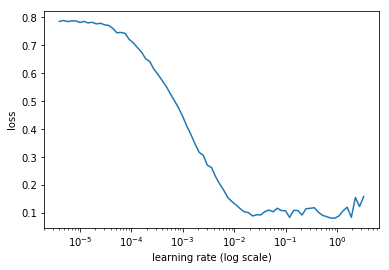

In [11]:
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()